# APS 3

___

####  <font style='font-family:Georgia' color='darkturquoise'> Arthur

### Importando bibliotecas e valores

In [172]:
from funcoesTermosol import *
import numpy as np
import math
from time import perf_counter

In [173]:
def matprint(mat, fmt="g"):        # Credits to braingineer https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Representação da estrutura

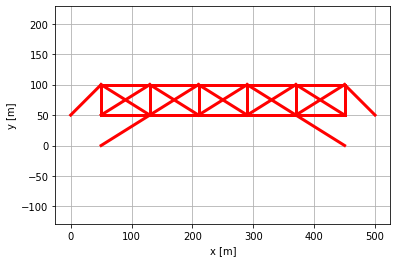

In [174]:
entrada = "entradaFinal.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [175]:
# Comprimento 
L = 4
#numero de nodes
n = 8

### Gerando a matriz de conectividade transposta

In [176]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
matprint(C_t)

 0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
-1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0  -1   0  
 1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0  
 0   1  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  -1  -1   0   0   0  
 0   0   1  -1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0  -1   0   0  
 0   0   0   1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0  -1   0   0   0   0   1   0   0   0   0   0   0  
 0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0  -1  
 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0  
 0   0   0   0   0  -1   0   0  

### Matriz dos membros (M)

In [177]:
M = np.matmul(N, C_t)
print(M)

[[ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  50.  80.  80.  80.
   80.  80.  50.  80.  80.   0.   0.   0.   0.   0.   0.  80. -80.  80.
   80. -80.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  50. -50.  50. -50.
  -50.  50. -50.  50. -50.  50. -50. -50. -50. -50. -50.  50.  50.  50.
   50.  50.]]


### Obtendo Se, Ke e Kg

In [178]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 16970.56274848  16970.56274848      0.         ...      0.
       0.              0.        ]
 [ 16970.56274848  16970.56274848      0.         ...      0.
       0.              0.        ]
 [     0.              0.          48293.89599651 ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ...   7146.05312364
       0.              0.        ]
 [     0.              0.              0.         ...      0.
   18293.89599651 -11433.68499782]
 [     0.              0.              0.         ...      0.
  -11433.68499782   7146.05312364]]


### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [179]:
F_c = np.delete(F, R.astype(int))
F_c


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 75.,  0., 75.,  0.,  0.,  0.,  0.])

Aplicando as condições de contorno para a matriz da rigidez:

In [180]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
matprint(Kg_c)

 48293.9    -30000         0         0         0         0         0         0         0         0         0         0  -18293.9  -11433.7         0         0         0         0         0         0         0         0  
  -30000    114882   11433.7    -30000         0         0         0         0         0         0  -18293.9   11433.7         0         0  -18293.9  -11433.7         0         0         0         0         0         0  
       0   11433.7   69438.2         0         0         0         0         0         0         0   11433.7  -7146.05         0    -48000  -11433.7  -7146.05         0         0         0         0         0         0  
       0    -30000         0   96587.8         0    -30000         0         0         0         0         0         0  -18293.9   11433.7         0         0  -18293.9  -11433.7         0         0         0         0  
       0         0         0         0   62292.1         0         0         0         0         0         0        

___
**Funções de Jacobi e Gauss-Seidel utilizadas na aula 21:**

In [181]:
# def jacobi(k,F,ite,tol):
#     #inicializando X com 
#     x = np.zeros(k.shape[0])

#     # Cria um vetor com os elementos da diagonal de k                       
#     diagonal = np.diag(k)
#     # Subtrai a diagonal de K
#     k_d = k - np.diagflat(diagonal)
#     # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
#     for i in range(ite):
#         x2 = (F - np.matmul(k_d,x)) / diagonal
#         error =  max(abs((x2 - x)/x2) )
#         if error < tol:
#             print(f"Erro máximo: {error}")
#             print(f"Convergiu na iteração: {i}")
#             return x2
        
#         x = x2
#     return x
def jacobi(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

In [182]:
# def gauss_seidel(A, b, ite, tol):
#     x = np.zeros_like(b, dtype=np.double)
    
#     #Iterate
#     for k in range(ite):
        
#         x_old  = x.copy()
        
#         #Loop over rows
#         for i in range(A.shape[0]):
#             x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
#         #Stop condition 
#         if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
#             break
            
#     return x
def gauss_seidel(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U_[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

___
Utilizando Jacobi, Gauss-Seidel e a forma geral para cálculo da matriz **U**

In [183]:
u_jacobi = jacobi(Kg_c, F_c, 1000, 1e-5)
print("Método Jacobi:")
timer_start = perf_counter()
matprint(jacobi(Kg_c, F_c,1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 425
Método Jacobi:
Iterações: 425
   0.0021178  
  0.00186405  
  0.00686966  
  0.00228434  
   0.0181262  
 0.000451815  
   0.0189259  
 0.000337058  
  0.00847579  
  0.00498641  
 -0.00166917  
 0.000513337  
 -0.00205502  
  0.00734235  
-0.000723277  
   0.0183898  
  0.00290908  
   0.0191968  
  0.00481284  
  0.00878521  
   0.0050977  
 0.000111284  
Tempo: 0.2683096190012293


In [184]:
u_gauss = gauss_seidel(Kg_c, F_c, 1000, 1e-5)
print("Método Gauss-Seidel:")
timer_start = perf_counter()
matprint(gauss_seidel(Kg_c, F_c, 1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 214
Método Gauss-Seidel:
Iterações: 214
   0.0021178  
  0.00186405  
  0.00686967  
  0.00228434  
   0.0181262  
 0.000451818  
    0.018926  
 0.000337057  
  0.00847581  
  0.00498642  
 -0.00166918  
 0.000513338  
 -0.00205503  
  0.00734236  
-0.000723283  
   0.0183898  
  0.00290908  
   0.0191968  
  0.00481285  
  0.00878524  
  0.00509772  
 0.000111285  
Tempo: 0.13765894300013315


**Deslocamentos nodais**

In [185]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([ 0.00211792,  0.00186415,  0.00686989,  0.00228448,  0.01812677,
        0.00045191,  0.01892663,  0.00033712,  0.0084762 ,  0.00498669,
       -0.0016692 ,  0.00051334, -0.00205505,  0.00734259, -0.00072326,
        0.01839038,  0.00290923,  0.01919746,  0.00481308,  0.00878563,
        0.00509798,  0.00011129])

**Ajustando o tamanho das matrizes U**

In [186]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.        ],
       [ 0.        ],
       [ 0.0021178 ],
       [ 0.        ],
       [ 0.00186405],
       [ 0.00686966],
       [ 0.00228434],
       [ 0.01812616],
       [ 0.00045182],
       [ 0.01892593],
       [ 0.00033706],
       [ 0.00847579],
       [ 0.        ],
       [ 0.        ],
       [ 0.00498641],
       [ 0.        ],
       [-0.00166917],
       [ 0.00051334],
       [-0.00205502],
       [ 0.00734235],
       [-0.00072328],
       [ 0.01838979],
       [ 0.00290908],
       [ 0.01919678],
       [ 0.00481284],
       [ 0.00878521],
       [ 0.0050977 ],
       [ 0.00011128],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [187]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.        ],
       [ 0.        ],
       [ 0.0021178 ],
       [ 0.        ],
       [ 0.00186405],
       [ 0.00686967],
       [ 0.00228434],
       [ 0.01812618],
       [ 0.00045182],
       [ 0.01892596],
       [ 0.00033706],
       [ 0.00847581],
       [ 0.        ],
       [ 0.        ],
       [ 0.00498642],
       [ 0.        ],
       [-0.00166918],
       [ 0.00051334],
       [-0.00205503],
       [ 0.00734236],
       [-0.00072328],
       [ 0.01838982],
       [ 0.00290908],
       [ 0.01919682],
       [ 0.00481285],
       [ 0.00878524],
       [ 0.00509772],
       [ 0.00011128],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [188]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u

array([[ 0.        ],
       [ 0.        ],
       [ 0.00211792],
       [ 0.        ],
       [ 0.00186415],
       [ 0.00686989],
       [ 0.00228448],
       [ 0.01812677],
       [ 0.00045191],
       [ 0.01892663],
       [ 0.00033712],
       [ 0.0084762 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.00498669],
       [ 0.        ],
       [-0.0016692 ],
       [ 0.00051334],
       [-0.00205505],
       [ 0.00734259],
       [-0.00072326],
       [ 0.01839038],
       [ 0.00290923],
       [ 0.01919746],
       [ 0.00481308],
       [ 0.00878563],
       [ 0.00509798],
       [ 0.00011129],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

### Reações de apoio

In [189]:
P = np.matmul(Kg,u)
P

array([[ 1.96154806e+01],
       [ 1.96154806e+01],
       [ 0.00000000e+00],
       [-2.93986569e+01],
       [-1.42108547e-14],
       [-7.63833441e-14],
       [ 0.00000000e+00],
       [-9.94759830e-14],
       [-1.42108547e-14],
       [ 1.35003120e-13],
       [ 1.42108547e-14],
       [ 3.19744231e-14],
       [ 2.28843671e+00],
       [-1.30932752e+01],
       [-3.99680289e-15],
       [ 3.99680289e-15],
       [ 2.84217094e-14],
       [ 3.55271368e-15],
       [-8.52651283e-14],
       [ 9.32587341e-15],
       [ 0.00000000e+00],
       [ 7.50000000e+01],
       [ 4.26325641e-14],
       [ 7.50000000e+01],
       [-8.52651283e-14],
       [-1.23456800e-13],
       [ 4.26325641e-14],
       [-7.10542736e-15],
       [-1.12650797e+02],
       [-7.04067484e+01],
       [ 9.07468801e+01],
       [-5.67168001e+01]])

In [190]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[ 1.96154806e+01],
       [ 1.96154806e+01],
       [-2.93986569e+01],
       [-1.12650797e+02],
       [-7.04067484e+01],
       [ 2.28843671e+00],
       [-1.30932752e+01],
       [ 3.99680289e-15],
       [ 9.07468801e+01],
       [-5.67168001e+01]])

### Deformações, Tenões e Forças internas

In [191]:
deformacoes=[]
tensoes=[]
forcas=[]
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    
    E =  Inc[i, 2]
    A = Inc[i,3]
    const = E*A/L
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)



In [192]:
deformacoes

[array([-3.17209998e-06]),
 array([5.25412484e-06]),
 array([-2.29071162e-05]),
 array([-1.43486754e-06]),
 array([-4.21404719e-06]),
 array([-4.82309931e-06]),
 array([1.66473606e-05]),
 array([4.54060193e-05]),
 array([2.37981675e-05]),
 array([3.56128764e-06]),
 array([-1.15585328e-05]),
 array([-3.95050034e-06]),
 array([4.14642219e-05]),
 array([7.55064152e-06]),
 array([3.71117874e-05]),
 array([-4.19964005e-06]),
 array([0.]),
 array([5.5351328e-05]),
 array([4.45887685e-05]),
 array([1.02668779e-05]),
 array([9.4539125e-06]),
 array([5.27217434e-06]),
 array([5.41649138e-06]),
 array([6.18859683e-06]),
 array([2.22580477e-06]),
 array([1.16307792e-05]),
 array([-2.15782978e-05]),
 array([-1.7770457e-05]),
 array([3.74069142e-06]),
 array([6.09383587e-06])]

In [193]:
tensoes
print(max(tensoes))
print(abs(min(tensoes)))

[221405.31192264]
[91628.46462937]


In [194]:
forcas

[array([-7.61303994]),
 array([12.60989961]),
 array([-54.97707878]),
 array([-3.44368211]),
 array([-10.11371326]),
 array([-11.57543834]),
 array([39.95366553]),
 array([108.97444627]),
 array([57.11560208]),
 array([8.54709033]),
 array([-27.74047864]),
 array([-9.48120082]),
 array([99.51413256]),
 array([18.12153965]),
 array([89.06828976]),
 array([-10.07913611]),
 array([0.]),
 array([132.84318715]),
 array([107.01304438]),
 array([24.64050695]),
 array([22.68938999]),
 array([12.65321842]),
 array([12.99957931]),
 array([14.85263238]),
 array([5.34193146]),
 array([27.91387004]),
 array([-51.78791481]),
 array([-42.64909683]),
 array([8.9776594]),
 array([14.6252061])]

___
**Gerando Saídas com as 3 matrizes U calculadas anteriormente**

In [195]:
x = geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [196]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [197]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)